In [1]:
import pandas as pd
import numpy as np
from rich import print
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
import warnings
import tqdm
from sklearn.cluster import DBSCAN
import itertools as it
from matplotlib import gridspec

In [2]:
def counts2flux(cps, band):
    scale = 1.4e-15 if band == 'FUV' else 2.06e-16
    return scale*cps

def counts2mag(cps, band):
    scale = 18.82 if band == 'FUV' else 20.08
    # This threw a warning if the countrate was negative which happens when
    #  the background is brighter than the source. Suppress.
    with np.errstate(invalid='ignore'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mag = -2.5 * np.log10(cps) + scale
    return mag

def mag2counts(mag, band):
    scale = 18.82 if band == 'FUV' else 20.08
    return 10.**(-(mag-scale)/2.5)

def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg


In [3]:
tbl_visit = pd.read_csv('gfcat_visit_table_lcstats.csv',index_col=0)
#tbl.replace('--',np./nan,inplace=True)

In [4]:
print(len(tbl_visit.index))

1959

In [5]:
#for i in tqdm.tqdm(tbl.index.tolist()):
#    visit = tbl.iloc[i]
#    e = visit['eclipse']
#    edir = str(e).zfill(5)
#    epath = f"../data/lightcurves/e{edir}"
#    ra,dec = visit['ra'],visit['dec']
#    otype = visit['simbad_otype'].split(',')[0]

In [6]:
pos = list(zip(tbl_visit['ra'].values,tbl_visit['dec'].values))
labels = DBSCAN(eps=17.5/60/60,min_samples=1).fit(pos).labels_
tbl_visit['gfcat_objid']=None
tbl_coadd = pd.DataFrame()
for lbl in tqdm.tqdm(np.unique(labels)):
    lbl_ix = np.where(labels==lbl)
    ix = tbl_visit.index[lbl_ix]
    this_source = tbl_visit.loc[ix]
    # To confirm that our flaring binaries are resolved
    #if 27109 in this_source['eclipse'].values:
    #    print(this_source)
    pos = (np.median(this_source['ra'].values),
           np.median(this_source['dec'].values))
    c = coord.SkyCoord(pos[0],pos[1],unit=(u.deg, u.deg))
    gfcat_objid = (f"GFCAT J" +
                   f"{str(int(c.ra.hms[0])).zfill(3)}"
                   f"{str(int(c.ra.hms[1])).zfill(2)}" +
                   f"{str(c.ra.hms[2]).split('.')[0].zfill(2)}." +
                   f"{str(c.ra.hms[2]).split('.')[1][0]}" +
                   f"{'+' if c.dec.dms[0]>0 else '-'}" +
                   f"{str(abs(int(c.dec.dms[0]))).zfill(2)}" +
                   f"{str(abs(int(c.dec.dms[1]))).zfill(2)}" +
                   f"{str(str(abs(c.dec.dms[2])).split('.')[0]).zfill(2)}." +
                   f"{str(c.dec.dms[2]).split('.')[1][0]}")
    # assign the gfcat objid to all entries in the visit table
    tbl_visit.loc[ix,'gfcat_objid'] = gfcat_objid
    # populate the coadd / object table
    tbl_coadd = pd.concat([tbl_coadd,pd.DataFrame({'gfcat_objid':[gfcat_objid],
                                  'ra':[pos[0]],'dec':[pos[1]],
                                  'n_gfcat':[len(this_source)],
                                  'simbad_id':[', '.join(list(set(this_source['simbad_main_id'].values)))],
                                  'simbad_otype':', '.join(list(set(it.chain(*[otypes.split(', ') for otypes in this_source['simbad_otype'].values])))),
                                  'simbad_match_offset':min(this_source['simbad_match_offset'].values),
                                  'simbad_n_match':max(this_source['simbad_n_match'].values)})])
    #tbl_visit[['eclipse','ra','dec','gfcat_objid']]
tbl_coadd.to_csv('gfcat_coadd_table.csv',index=None)
tbl_coadd

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1426/1426 [00:03<00:00, 388.13it/s]


,gfcat_objid,ra,dec,n_gfcat,simbad_id,simbad_otype,simbad_match_offset,simbad_n_match
0,GFCAT J0163938.3+410644.4,249.909726,41.112356,9,V* AF Her,RRLyrae,2.021917384975026,1
0,GFCAT J0204615.6-045550.4,311.565113,-4.930670,1,2MASS J20461427-0456025,Low-Mass*,23.58975724917362,0
0,GFCAT J0210344.4-072245.2,315.935391,-7.379244,1,2MASS J21034437-0722434,Low-Mass*,0.7203244462531776,1
0,GFCAT J0225324.6-394735.3,343.352675,-39.793149,2,LEDA 2794348,Galaxy,31.206438874927272,0
0,GFCAT J0171746.8+594122.6,259.445027,59.689634,2,2MASS J17174656+5941240,Star,2.138868229789633,1
...,...,...,...,...,...,...,...,...
0,GFCAT J0123528.3-365215.2,188.868257,-36.870892,1,CRTS J123528.2-365214,"Star, RRLyrae",2.5626142878286764,1
0,GFCAT J0121242.3-265536.8,183.176317,-26.926904,1,2MASS J12124204-2655328,HighPM*,5.210579871203921,1
0,GFCAT J0121616.6-302151.7,184.069175,-30.364380,1,UCAC2 19153424,Star,8.818929739376449,1
0,GFCAT J0121450.5-322554.3,183.710681,-32.431776,1,--,--,--,0


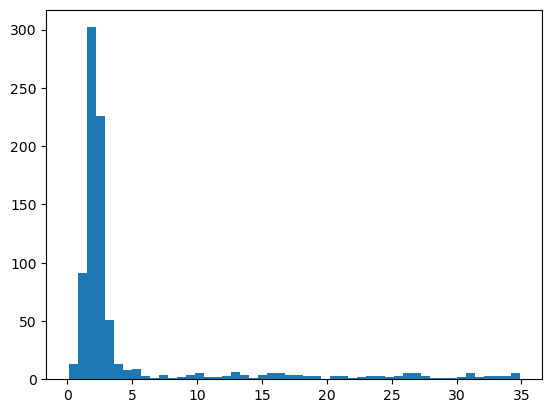

In [7]:
# most objects with simbad matches are very good matches (<5as)
plt.hist(np.array(tbl_coadd['simbad_match_offset'].replace('--',np.nan),dtype=float),bins=50);

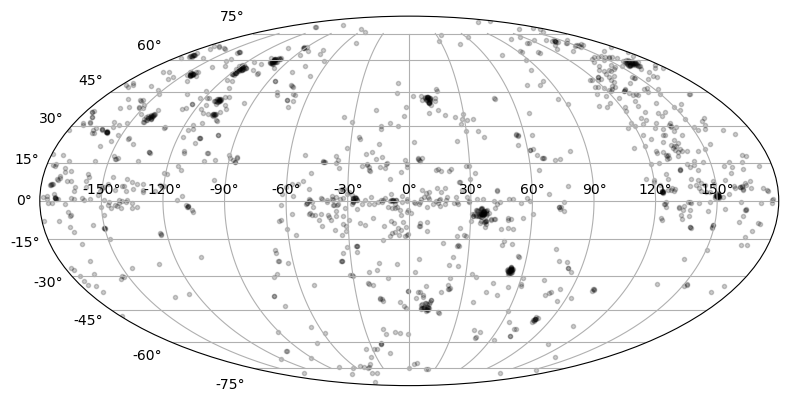

In [8]:
ra = coord.Angle(tbl_coadd['ra'],unit=u.degree)
dec = coord.Angle(tbl_coadd['dec'],unit=u.degree)
ra = ra.wrap_at(180*u.degree)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian, alpha=0.2, marker='.', color='k')
ax.grid(True)
plt.tight_layout()
plt.savefig('total_coverage.png',dpi=150)
plt.savefig('total_coverage.pdf',dpi=150)

Text(0, 0.5, 'max mags')

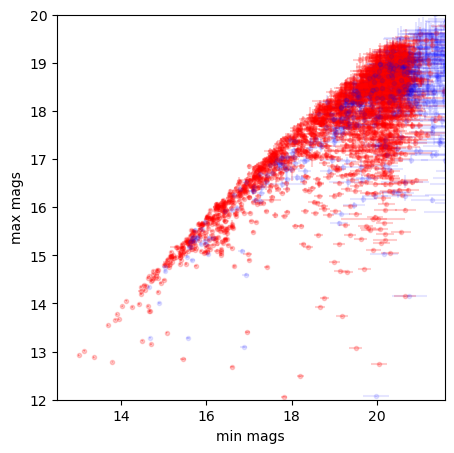

In [9]:
tbl_visit.replace('--',np.nan,inplace=True)
plt.figure(figsize=(5,5))
plt.errorbar(np.array(tbl_visit['mag_min_NUV'],dtype=float),
             np.array(tbl_visit['mag_max_NUV'],dtype=float),
             xerr=np.array(tbl_visit['mag_min_err_NUV'],dtype=float),
             yerr=np.array(tbl_visit['mag_max_err_NUV'],dtype=float),
             fmt='.',marker=None,color='r',alpha=0.2)
plt.errorbar(np.array(tbl_visit['mag_min_FUV'],dtype=float),
             np.array(tbl_visit['mag_max_FUV'],dtype=float),
             xerr=np.array(tbl_visit['mag_min_err_FUV'],dtype=float),
             yerr=np.array(tbl_visit['mag_max_err_FUV'],dtype=float),
             fmt='.',marker=None,color='b',alpha=0.1)
plt.xlim([12.5,counts2mag(0.25,'NUV')])
plt.ylim([12,20])
plt.xlabel('min mags')
plt.ylabel('max mags')

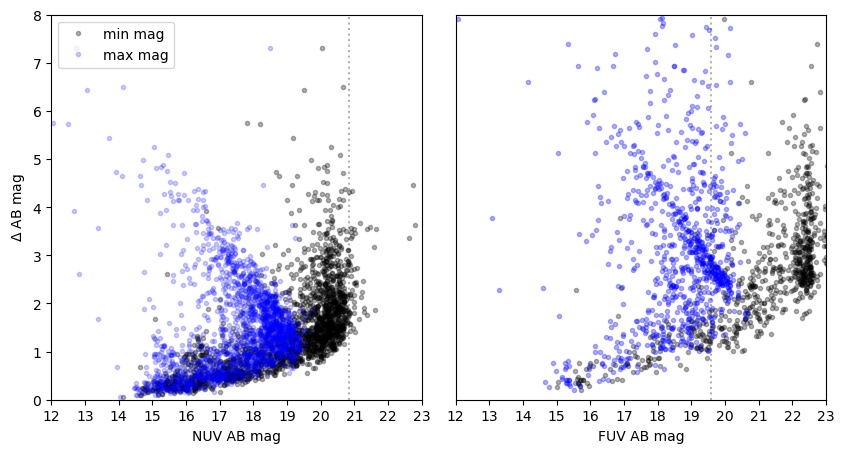

In [10]:
gs = gridspec.GridSpec(nrows=2, ncols=4)
fig = plt.figure(figsize=(10,5))

ix = np.where((tbl_visit['qa_flag_nuv']==0))
ax = fig.add_subplot(gs[:2,:2])
#for cps in [0.5,1,2,4,8,16,32,64]:
ax.vlines(counts2mag(0.5,'NUV'),0,8,linestyle='dotted',color='k',alpha=0.3)
#    ax.fill_betweenx([0,8],counts2mag(cps,'NUV'),counts2mag(cps+3*np.sqrt(cps*30)/30,'NUV'),
#                     facecolor='gray',alpha=0.2)
#    ax.fill_betweenx([0,8],counts2mag(cps-3*np.sqrt(cps*30)/30,'NUV'),
#                           counts2mag(cps+3*np.sqrt(cps*30)/30,'NUV'),
#                     facecolor='gray',alpha=0.2)

ax.plot(np.array(tbl_visit['mag_min_NUV'].iloc[ix],dtype=float),
         np.abs(np.array(tbl_visit['mag_min_NUV'].iloc[ix],dtype=float)-
                np.array(tbl_visit['mag_max_NUV'].iloc[ix],dtype=float)),'k.',alpha=0.3,
         label='min mag')
ax.plot(np.array(tbl_visit['mag_max_NUV'].iloc[ix],dtype=float),
         np.abs(np.array(tbl_visit['mag_min_NUV'].iloc[ix],dtype=float)-
                np.array(tbl_visit['mag_max_NUV'].iloc[ix],dtype=float)),'b.',alpha=0.2,
        label='max mag')
ax.set_xlabel("NUV AB mag")
ax.set_ylabel(r"$\Delta$ AB mag")
ax.set_xticks(np.arange(12,24))
ax.set_xlim([12,23])
ax.set_yticks(np.arange(0,9))
ax.set_ylim([0,8])
ax.legend(loc='upper left');

ix = np.where((tbl_visit['qa_flag_fuv']==0))
ax = fig.add_subplot(gs[:,2:])
ax.plot(np.array(tbl_visit['mag_min_FUV'].iloc[ix],dtype=float),
         np.abs(np.array(tbl_visit['mag_min_FUV'].iloc[ix],dtype=float)-
                np.array(tbl_visit['mag_max_FUV'].iloc[ix],dtype=float)),
        'k.',alpha=0.3,label='mag_min')
ax.plot(np.array(tbl_visit['mag_max_FUV'].iloc[ix],dtype=float),
         np.abs(np.array(tbl_visit['mag_min_FUV'].iloc[ix],dtype=float)-
                np.array(tbl_visit['mag_max_FUV'].iloc[ix],dtype=float)),
        'b.',alpha=0.3,label='mag_max')
ax.vlines(counts2mag(0.5,'FUV'),0,8,linestyle='dotted',color='k',alpha=0.3)
ax.set_xlabel("FUV AB mag")
ax.set_xticks(np.arange(12,24))
ax.set_xlim([12,23])
ax.set_ylim([0,8])
ax.set_yticks([]);
#ax.legend(loc='upper left')
plt.savefig('delta_mag_vs_mag.png',dpi=150)
plt.savefig('delta_mag_vs_mag.pdf',dpi=150)

### Visit-level table

In [19]:
tbl_visit.keys()

Index(['eclipse', 'obj_id', 'ra', 'dec', 'simbad_n_match', 'simbad_otype',
       'simbad_main_id', 'simbad_distance', 'simbad_distance_err_2',
       'simbad_distance_err_1', 'simbad_parallax', 'simbad_parallax_err',
       'simbad_match_offset', 'obstart', 'datetime_iso', 'datetime_decimal',
       'gaia_match_offset', 'gaia_n_match', 'gaia_dr3_source_id',
       'gaia_distance', 'gaia_distance_err_2', 'gaia_distance_err_1',
       'gaia_parallax', 'gaia_parallax_err', 'gaia_parallax_over_err', 'pmra',
       'pmdec', 'gaia_ra', 'gaia_dec', 'distance', 'distance_err_1',
       'distance_err_2', 'cps_min_NUV', 'cps_min_err_NUV', 'mag_min_NUV',
       'mag_min_err_NUV', 'cps_max_NUV', 'cps_max_err_NUV', 'mag_max_NUV',
       'mag_max_err_NUV', 'cps_mean_NUV', 'cps_mean_err_NUV', 'mag_mean_NUV',
       'mag_mean_err_NUV', 'tstart_NUV', 'tstop_NUV', 'expt_raw_NUV',
       'cps_min_FUV', 'cps_min_err_FUV', 'mag_min_FUV', 'mag_min_err_FUV',
       'cps_max_FUV', 'cps_max_err_FUV', 'mag_max

In [12]:
# LaTeX for a stub table for the visit data.
print(latex := tbl_visit.sort_values('eclipse').replace('--',np.nan).astype(
     {'ra':float,'dec':float,'mag_mean_NUV':float,'mag_mean_err_NUV':float,'mag_mean_FUV':float,
      'mag_mean_err_FUV':float,'mag_min_NUV':float,'mag_min_err_NUV':float,'mag_max_NUV':float,'mag_max_err_NUV':float,
      'mag_min_FUV':float,'mag_min_err_FUV':float,'mag_max_FUV':float,'mag_max_err_FUV':float,
      'qa_flag_nuv':int,'qa_flag_fuv':int}).round(
     {'ra':2,'dec':2,'mag_mean_NUV':2,'mag_mean_err_NUV':2,'mag_mean_FUV':2,'mag_mean_err_FUV':2,
      'mag_min_NUV':2,'mag_min_err_NUV':2,'mag_min_FUV':2,'mag_min_err_FUV':2,'mag_max_NUV':2,'mag_max_err_NUV':2,
      'mag_max_FUV':2,'mag_max_err_FUV':2}).replace(np.nan,'--')[
    ['eclipse','ra','dec',
     'mag_mean_NUV','mag_mean_err_NUV',
     'mag_mean_FUV','mag_mean_err_FUV',
     'mag_min_NUV','mag_min_err_NUV',
     'mag_min_FUV','mag_min_err_FUV',
     'mag_max_NUV','mag_max_err_NUV',
     'mag_max_FUV','mag_max_err_FUV',
     'qa_flag_nuv','qa_flag_fuv']].iloc[80:100].to_latex(index=False))

/var/folders/jh/l3nkzcmx52zbg2p91vw7h27r0000gn/T/ipykernel_8105/3612835177.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex := tbl_visit.sort_values('eclipse').replace('--',np.nan).astype(


\begin{tabular}{rrrllllllllllllrr}
\toprule
 eclipse &     ra &    dec & mag\_mean\_NUV & mag\_mean\_err\_NUV & mag\_mean\_FUV & mag\_mean\_err\_FUV & 
mag\_min\_NUV & mag\_min\_err\_NUV & mag\_min\_FUV & mag\_min\_err\_FUV & mag\_max\_NUV & mag\_max\_err\_NUV & 
mag\_max\_FUV & mag\_max\_err\_FUV &  qa\_flag\_nuv &  qa\_flag\_fuv \\
\midrule
    4217 &  80.01 & -49.08 &        19.52 &             0.02 &         20.3 &             0.06 &       20.25 &     
0.21 &       21.68 &            0.57 &       18.41 &            0.09 &        19.0 &             0.2 &            0
&            0 \\
    4218 & 149.82 &   1.85 &        19.73 &             0.03 &         21.0 &             0.08 &       20.24 &     
0.21 &       22.58 &            0.77 &       19.35 &            0.14 &       20.06 &             0.3 &            1
&            0 \\
    4231 &  79.29 & -49.24 &        19.27 &             0.02 &        20.08 &             0.06 &        20.2 &     
0.26 &       22.47 &            0.75 &       18.05 &            0.08 &        18.7 &            0.17 &            0
&            0 \\
    4245 &  79.25 & -48.87 &        16.03 &             0.01 &        19.91 &             0.06 &       16.16 &     
0.03 &        20.5 &            0.36 &       15.76 &            0.07 &       19.49 &            0.24 &            0
&            0 \\
    4262 & 150.39 &   1.72 &        18.19 &             0.01 &        21.09 &             0.08 &       18.65 &     
0.1 &       22.41 &            0.73 &       17.73 &            0.07 &       20.12 &            0.31 &            0 
&            0 \\
    4278 & 150.39 &   1.72 &        17.68 &             0.01 &        20.45 &             0.06 &       18.16 &     
0.08 &       22.03 &            0.73 &       17.38 &            0.06 &       19.37 &            0.23 &            0
&            0 \\
    4282 & 150.47 &   2.20 &        19.06 &             0.03 &        21.07 &              0.1 &       19.39 &     
0.14 &       22.53 &            0.76 &       18.57 &             0.1 &       19.92 &            0.29 &            0
&            0 \\
    4310 & 150.45 &   2.98 &        19.37 &             0.02 &        20.98 &             0.08 &       20.21 &     
0.44 &       22.51 &            0.76 &        18.8 &            0.11 &       20.05 &             0.3 &            0
&            0 \\
    4322 & 149.97 &   2.78 &        19.72 &             0.03 &        21.15 &             0.08 &        20.3 &     
0.21 &       22.58 &            0.77 &       19.14 &            0.13 &       20.15 &            0.32 &            0
&            0 \\
    4325 & 149.50 &   2.08 &        19.72 &             0.03 &        21.19 &             0.09 &        20.4 &     
0.22 &       26.61 &            2.21 &       18.26 &            0.09 &       19.03 &             0.2 &            0
&            0 \\
    4341 & 150.08 &   1.45 &        19.24 &             0.03 &           -- &               -- &        19.7 &     
0.16 &          -- &              -- &       18.42 &            0.09 &          -- &              -- &            0
&            0 \\
    4355 & 150.47 &   2.20 &        19.02 &             0.02 &        20.63 &             0.07 &       19.57 &     
0.16 &       22.49 &            0.75 &       18.23 &            0.14 &       19.36 &            0.23 &            0
&            0 \\
    4365 & 150.39 &   1.72 &        17.91 &             0.01 &        20.89 &             0.07 &       18.46 &     
0.1 &       22.46 &            0.74 &       17.52 &            0.06 &       19.93 &            0.29 &            0 
&            0 \\
    4369 & 150.53 &   2.38 &        18.81 &             0.02 &        19.63 &             0.04 &       19.76 &     
0.17 &       21.54 &            0.54 &       17.19 &            0.05 &       17.79 &            0.12 &            0
&            0 \\
    4406 & 150.54 &   2.12 &        18.95 &             0.02 &        19.63 &             0.05 &       20.27 &     
0.21 &       22.39 &            0.73 & 

In [13]:
# reformat the latex how I want.
print('\\begin{tabular}{rrrrrrrrrrr}')
print('\\toprule')
print('eclipse & RA    & Dec   & NUV mean & FUV mean & NUV min  & FUV min  & NUV max  & FUV max  & NUV & FUV \\\\')
print('         & (deg) & (deg) & (AB mag) & (AB mag) & (AB mag) & (AB mag) & (AB mag) & (AB mag) & QA  & QA \\\\')
print('\\midrule')
for row in latex.split('\n')[4:-3]:
    #print(row)
    e=row.split('&')
    line = (
     f"{e[0].strip()} & {e[1].strip()} & {e[2].strip()} & " +
     f"{e[3].strip()}$"+"\pm{"+f"{e[4].strip()}"+"}$ & " +
     f"{e[5].strip()}$"+"\pm{"+f"{e[6].strip()}"+"}$ & " +
     f"{e[7].strip()}$"+"\pm{"+f"{e[8].strip()}"+"}$ & " +
     f"{e[9].strip()}$"+"\pm{"+f"{e[10].strip()}"+"}$ & " +
     f"{e[11].strip()}$"+"\pm{"+f"{e[12].strip()}"+"}$ & " +
     f"{e[13].strip()}$"+"\pm{"+f"{e[14].strip()}"+"}$ & " +
     f"{e[15].strip()} & {e[16].strip()}")
    print(line)
for row in latex.split('\n')[-3:]:
    print(row)

\begin{tabular}{rrrrrrrrrrr}

\toprule

eclipse & RA    & Dec   & NUV mean & FUV mean & NUV min  & FUV min  & NUV max  & FUV max  & NUV & FUV \\

& (deg) & (deg) & (AB mag) & (AB mag) & (AB mag) & (AB mag) & (AB mag) & (AB mag) & QA  & QA \\

\midrule

4217 & 80.01 & -49.08 & 19.52$\pm{0.02}$ & 20.3$\pm{0.06}$ & 20.25$\pm{0.21}$ & 21.68$\pm{0.57}$ & 18.41$\pm{0.09}$
& 19.0$\pm{0.2}$ & 0 & 0 \\

4218 & 149.82 & 1.85 & 19.73$\pm{0.03}$ & 21.0$\pm{0.08}$ & 20.24$\pm{0.21}$ & 22.58$\pm{0.77}$ & 19.35$\pm{0.14}$ 
& 20.06$\pm{0.3}$ & 1 & 0 \\

4231 & 79.29 & -49.24 & 19.27$\pm{0.02}$ & 20.08$\pm{0.06}$ & 20.2$\pm{0.26}$ & 22.47$\pm{0.75}$ & 18.05$\pm{0.08}$
& 18.7$\pm{0.17}$ & 0 & 0 \\

4245 & 79.25 & -48.87 & 16.03$\pm{0.01}$ & 19.91$\pm{0.06}$ & 16.16$\pm{0.03}$ & 20.5$\pm{0.36}$ & 15.76$\pm{0.07}$
& 19.49$\pm{0.24}$ & 0 & 0 \\

4262 & 150.39 & 1.72 & 18.19$\pm{0.01}$ & 21.09$\pm{0.08}$ & 18.65$\pm{0.1}$ & 22.41$\pm{0.73}$ & 17.73$\pm{0.07}$ 
& 20.12$\pm{0.31}$ & 0 & 0 \\

4278 & 150.39 & 1.72 & 17.68$\pm{0.01}$ & 20.45$\pm{0.06}$ & 18.16$\pm{0.08}$ & 22.03$\pm{0.73}$ & 17.38$\pm{0.06}$
& 19.37$\pm{0.23}$ & 0 & 0 \\

4282 & 150.47 & 2.20 & 19.06$\pm{0.03}$ & 21.07$\pm{0.1}$ & 19.39$\pm{0.14}$ & 22.53$\pm{0.76}$ & 18.57$\pm{0.1}$ &
19.92$\pm{0.29}$ & 0 & 0 \\

4310 & 150.45 & 2.98 & 19.37$\pm{0.02}$ & 20.98$\pm{0.08}$ & 20.21$\pm{0.44}$ & 22.51$\pm{0.76}$ & 18.8$\pm{0.11}$ 
& 20.05$\pm{0.3}$ & 0 & 0 \\

4322 & 149.97 & 2.78 & 19.72$\pm{0.03}$ & 21.15$\pm{0.08}$ & 20.3$\pm{0.21}$ & 22.58$\pm{0.77}$ & 19.14$\pm{0.13}$ 
& 20.15$\pm{0.32}$ & 0 & 0 \\

4325 & 149.50 & 2.08 & 19.72$\pm{0.03}$ & 21.19$\pm{0.09}$ & 20.4$\pm{0.22}$ & 26.61$\pm{2.21}$ & 18.26$\pm{0.09}$ 
& 19.03$\pm{0.2}$ & 0 & 0 \\

4341 & 150.08 & 1.45 & 19.24$\pm{0.03}$ & --$\pm{--}$ & 19.7$\pm{0.16}$ & --$\pm{--}$ & 18.42$\pm{0.09}$ & 
--$\pm{--}$ & 0 & 0 \\

4355 & 150.47 & 2.20 & 19.02$\pm{0.02}$ & 20.63$\pm{0.07}$ & 19.57$\pm{0.16}$ & 22.49$\pm{0.75}$ & 18.23$\pm{0.14}$
& 19.36$\pm{0.23}$ & 0 & 0 \\

4365 & 150.39 & 1.72 & 17.91$\pm{0.01}$ & 20.89$\pm{0.07}$ & 18.46$\pm{0.1}$ & 22.46$\pm{0.74}$ & 17.52$\pm{0.06}$ 
& 19.93$\pm{0.29}$ & 0 & 0 \\

4369 & 150.53 & 2.38 & 18.81$\pm{0.02}$ & 19.63$\pm{0.04}$ & 19.76$\pm{0.17}$ & 21.54$\pm{0.54}$ & 17.19$\pm{0.05}$
& 17.79$\pm{0.12}$ & 0 & 0 \\

4406 & 150.54 & 2.12 & 18.95$\pm{0.02}$ & 19.63$\pm{0.05}$ & 20.27$\pm{0.21}$ & 22.39$\pm{0.73}$ & 17.17$\pm{0.05}$
& 17.51$\pm{0.1}$ & 1 & 1 \\

4415 & 150.08 & 1.45 & 19.09$\pm{0.02}$ & 20.59$\pm{0.08}$ & 19.57$\pm{0.15}$ & 22.18$\pm{0.67}$ & 18.2$\pm{0.09}$ 
& 18.95$\pm{0.19}$ & 0 & 0 \\

4426 & 150.84 & 2.06 & 13.79$\pm{0.0}$ & 18.42$\pm{0.02}$ & 13.87$\pm{0.01}$ & 19.2$\pm{0.21}$ & 13.66$\pm{0.01}$ &
16.83$\pm{0.08}$ & 1 & 0 \\

4469 & 150.42 & 2.13 & 19.51$\pm{0.02}$ & 21.02$\pm{0.07}$ & 20.12$\pm{0.19}$ & 23.22$\pm{0.95}$ & 17.91$\pm{0.07}$
& 18.43$\pm{0.16}$ & 0 & 0 \\

4560 & 162.18 & 58.26 & 19.02$\pm{0.02}$ & --$\pm{--}$ & 19.65$\pm{0.16}$ & --$\pm{--}$ & 18.55$\pm{0.1}$ & 
--$\pm{--}$ & 1 & 0 \\

4580 & 164.09 & 57.09 & 17.51$\pm{0.01}$ & --$\pm{--}$ & 17.83$\pm{0.07}$ & --$\pm{--}$ & 17.28$\pm{0.06}$ & 
--$\pm{--}$ & 0 & 0 \\

\bottomrule

\end{tabular}

### Coadd-level table

In [14]:
# LaTeX for a stub table for the coadd / unique object data.
print(tbl_coadd.sort_values('ra')[['gfcat_objid','n_gfcat','simbad_id','simbad_otype']].iloc[:40].to_latex(index=False))

/var/folders/jh/l3nkzcmx52zbg2p91vw7h27r0000gn/T/ipykernel_8105/2708788136.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tbl_coadd.sort_values('ra')[['gfcat_objid','n_gfcat','simbad_id','simbad_otype']].iloc[:40].to_latex(index=False))


\begin{tabular}{lrll}
\toprule
              gfcat\_objid &  n\_gfcat &                      simbad\_id &         simbad\_otype \\
\midrule
GFCAT J0000403.0-044134.3 &        1 &          ATO J001.0125-04.6926 &            Variable* \\
GFCAT J0000859.6+233834.9 &        1 &                   ADS   106 AB &                   ** \\
GFCAT J0000912.6+425745.1 &        1 &                 TYC 2789-591-1 &              HighPM* \\
GFCAT J0000942.5-003347.7 &        1 &          ATO J002.4268-00.5629 &              RRLyrae \\
GFCAT J0001049.4-003855.2 &        1 &                             -- &                   -- \\
GFCAT J0001141.2-282109.7 &        1 &                             -- &                   -- \\
GFCAT J0001611.7-392722.8 &        4 &          CRTS J001611.7-392722 &              RRLyrae \\
GFCAT J0001722.4+163035.2 &        1 &                      HD   1309 &              X, Star \\
GFCAT J0001823.2+165144.2 &        1 &                             -- &                   -- \\
GFCAT J0001838.9-100416.6 &        1 &                  UCAC3 160-834 &                 Star \\
GFCAT J0001850.2+161503.0 &        1 &          2XMM J001850.1+161504 &                    X \\
GFCAT J0001850.8-722053.7 &        1 & SSTISAGEMA J001851.35-722108.7 & Star, RGB*\_Candidate \\
GFCAT J0001934.1-011035.2 &        1 &        2MASS J00193412-0110343 &            Low-Mass* \\
GFCAT J0001934.5-230955.0 &        1 &                SIPS J0019-2309 &              HighPM* \\
GFCAT J0001949.0-364619.7 &        1 &                             -- &                   -- \\
GFCAT J0002018.0-003526.7 &        1 &        2MASS J00201796-0035257 &             delSctV* \\
GFCAT J0002031.1-095135.9 &        1 &          ATO J005.1292-09.8597 &                  SB* \\
GFCAT J0002111.4-084142.5 &        1 &          1RXS J002112.1-084154 &                    X \\
GFCAT J0002144.5+154338.6 &        1 &                             -- &                   -- \\
GFCAT J0002242.5-005249.5 &        1 &                             -- &                   -- \\
GFCAT J0002504.5-364619.3 &        1 &                      G 267-100 &                   ** \\
GFCAT J0002513.2+041156.4 &        1 &                             -- &                   -- \\
GFCAT J0002544.1+170453.0 &        1 &                             -- &                   -- \\
GFCAT J0002652.1+425002.0 &        1 &                       G 171-59 &              HighPM* \\
GFCAT J0002801.1-423812.1 &        1 &                             -- &                   -- \\
GFCAT J0002843.2-440024.1 &        3 &                  SV* SON  4791 &              RRLyrae \\
GFCAT J0002851.0+410826.0 &        1 &                             -- &                   -- \\
GFCAT J0002858.3+013537.2 &        1 &                   HE 0026+0119 &              RRLyrae \\
GFCAT J0002918.5-443856.4 &        1 &                             -- &                   -- \\
GFCAT J0003028.6-441126.4 &        1 &                             -- &                   -- \\
GFCAT J0003039.8-380959.0 &        1 &               UCAC4 260-000506 &            Eruptive* \\
GFCAT J0003049.6-420252.9 &        1 &                             -- &                   -- \\
GFCAT J0003049.9-715043.0 &        1 & SSTISAGEMA J003050.00-715044.7 &                 Star \\
GFCAT J0003220.2-390001.5 &        1 &                             -- &                   -- \\
GFCAT J0003257.0+030539.7 &        1 &                             -- &                   -- \\
GFCAT J0003336.6-434915.6 &       11 &                    CD-44   135 & Variable*, EmissionG \\
GFCAT J0003410.2-120855.5 &        1 &   Gaia DR2 2375643997370225152 &             Star, ** \\
GFCAT J0003410.6-440502.6 &        1 &        2MASS J00341047-4405017 &            Eruptive* \\
GFCAT J0003442.4-081518.8 &        1 &                             -- &                   -- \\
GFCAT J0003515.2-022627.3 &        1 &      GALEX 2673143681802830594 &            QSO, blue \\
\bottomrule
\end{ta

In [16]:
# all unique otypes within the corpus
#all_otypes = ', '.join(list(set(it.chain(*[otypes.split(', ') for otypes in tbl_visit['simbad_otype'].values])))).replace('--, ','')
#print(all_otypes)

In [17]:
print(f"""GFCAT describes {len(tbl_visit)} measurements of intra-visit variability across {len(tbl_coadd)} sources.""")

GFCAT describes 1959 measurements of intra-visit variability across 1426 sources.

In [24]:
tbl_visit.keys()

Index(['eclipse', 'obj_id', 'ra', 'dec', 'simbad_n_match', 'simbad_otype',
       'simbad_main_id', 'simbad_distance', 'simbad_distance_err_2',
       'simbad_distance_err_1', 'simbad_parallax', 'simbad_parallax_err',
       'simbad_match_offset', 'obstart', 'datetime_iso', 'datetime_decimal',
       'gaia_match_offset', 'gaia_n_match', 'gaia_dr3_source_id',
       'gaia_distance', 'gaia_distance_err_2', 'gaia_distance_err_1',
       'gaia_parallax', 'gaia_parallax_err', 'gaia_parallax_over_err', 'pmra',
       'pmdec', 'gaia_ra', 'gaia_dec', 'distance', 'distance_err_1',
       'distance_err_2', 'cps_min_NUV', 'cps_min_err_NUV', 'mag_min_NUV',
       'mag_min_err_NUV', 'cps_max_NUV', 'cps_max_err_NUV', 'mag_max_NUV',
       'mag_max_err_NUV', 'cps_mean_NUV', 'cps_mean_err_NUV', 'mag_mean_NUV',
       'mag_mean_err_NUV', 'tstart_NUV', 'tstop_NUV', 'expt_raw_NUV',
       'cps_min_FUV', 'cps_min_err_FUV', 'mag_min_FUV', 'mag_min_err_FUV',
       'cps_max_FUV', 'cps_max_err_FUV', 'mag_max

In [37]:
ix = np.argsort(np.array(tbl_visit[tbl_visit['mag_min_NUV']!='--']['mag_min_NUV'],dtype=float)-
 np.array(tbl_visit[tbl_visit['mag_min_NUV']!='--']['mag_max_NUV'],dtype=float))

array([ 585, 1047,  613, ..., 1611,  548, 1696])

In [43]:
tbl_visit.iloc[ix][['mag_max_NUV','mag_min_NUV','ra','dec','simbad_main_id','simbad_otype']]

,mag_max_NUV,mag_min_NUV,ra,dec,simbad_main_id,simbad_otype
0,16.281005571974763,16.610268371688374,249.909813,41.112522,V* AF Her,RRLyrae
1,17.394955810791384,18.303600863590322,311.565113,-4.930670,2MASS J20461427-0456025,Low-Mass*
2,17.974534862630563,19.275883056794356,315.935391,-7.379244,2MASS J21034437-0722434,Low-Mass*
3,18.62984958260792,20.55241229759103,343.352654,-39.793072,LEDA 2794348,Galaxy
4,17.43499519810817,19.90769410778523,259.445075,59.689607,2MASS J17174656+5941240,Star
...,...,...,...,...,...,...
2059,16.960656104439426,17.940183967631746,188.868257,-36.870892,CRTS J123528.2-365214,"RRLyrae, Star"
2060,18.695742959782457,19.67293657283667,183.176317,-26.926904,2MASS J12124204-2655328,HighPM*
2061,18.613631512869468,19.455834129209425,184.069175,-30.364380,UCAC2 19153424,Star
2063,17.044986981044907,20.006731475075167,183.710681,-32.431776,NaN,NaN


In [58]:
tbl_visit['mag_diff'] = (np.array(tbl_visit.replace('--',np.nan)['mag_min_NUV'],dtype=float)-
 np.array(tbl_visit.replace('--',np.nan)['mag_max_NUV'],dtype=float))

In [66]:
tbl_visit.sort_values('mag_diff')[['eclipse','ra','dec','simbad_otype','simbad_main_id','mag_diff','mag_mean_NUV']]

,eclipse,ra,dec,simbad_otype,simbad_main_id,mag_diff,mag_mean_NUV
600,14596,141.960630,29.760911,Star,BD+30 1869,0.066275,14.093236142940835
1085,29643,53.065060,-29.510070,SB*,CD-29 1307,0.081831,14.719530106273371
630,15128,219.750919,64.290383,"BYDraV*, Star",V* EK Dra B,0.083386,12.966919539706023
1108,30696,134.096083,28.667034,HighPM*,HD 76332,0.087242,13.983018106473878
639,15251,194.858510,27.356320,"Galaxy, HotSubdwarf, LowSurfBrghtG, Star",HZ 47,0.094349,15.109271001324512
...,...,...,...,...,...,...,...
586,14346,150.165860,67.853042,NaN,NaN,7.302195,19.446976420242926
1152,31850,197.395818,28.984424,"Eruptive*, Star",G 164-47,7.309752,15.772911161421655
562,13794,4.049198,-39.456330,RRLyrae,CRTS J001611.7-392722,NaN,NaN
1684,17105,247.828587,40.864560,Eruptive*,G 180-60,NaN,NaN


In [76]:
# write the final visit-level catalog
tbl_visit.drop(['counts_9', 'counts_12_5',
                'counts_17_5', 'counts_25', 
                'counts_35'],axis=1).replace(np.nan,'--').to_csv('gfcat_visit_table.csv',index=None)

In [77]:
# write the final coadd-level catalog
tbl_coadd.replace(np.nan,'--').to_csv('gfcat_object_table.csv',index=None)